# Intel Image Classification (CNN - Keras)
Hello, I hope you are having a great day.

In this notebook, I will try the process of implementing CNN with Keras in order to classify images.

1. Firstly, we'll import usefull packages.
2. Then, we'll load the data, before visualize and preprocess it.
3. We'll try a simple CNN model and then we will evaluate its performances.
4. We will then use pre trained model to address this challenge aswell.

# Import Packages¶


In [1]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm
import pandas as pd
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

# Loading the Data
We have to write a load_data function that load the images and the labels from the folder.

In [2]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (150, 150)

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['seg_train', 'seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [10]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading seg_train


  0%|          | 2/437 [00:00<00:31, 13.93it/s]

Loading seg_test


100%|██████████| 501/501 [00:02<00:00, 232.15it/s]


In [11]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)


# Let's explore the dataset
We can ask ourselves:

* How many training and testing examples do we have ?
* What is the size of the images ?
* What is the proportion of each observed category ?

In [12]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


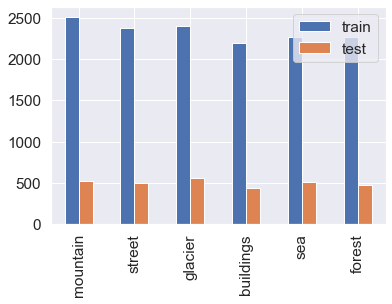

In [13]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

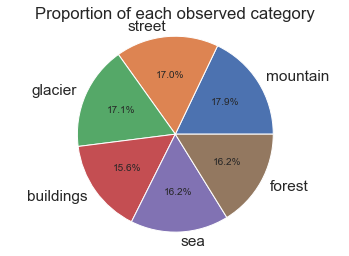

In [14]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

Good practice: scale the data¶


In [15]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# Visualize the data
We can display a random image from the training set.

In [17]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

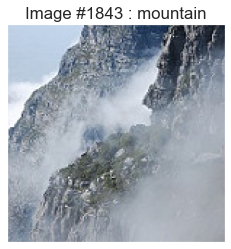

In [18]:
display_random_image(class_names, train_images, train_labels)


We can also display the first 25 images from the training set directly with a loop to get a better view


In [19]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

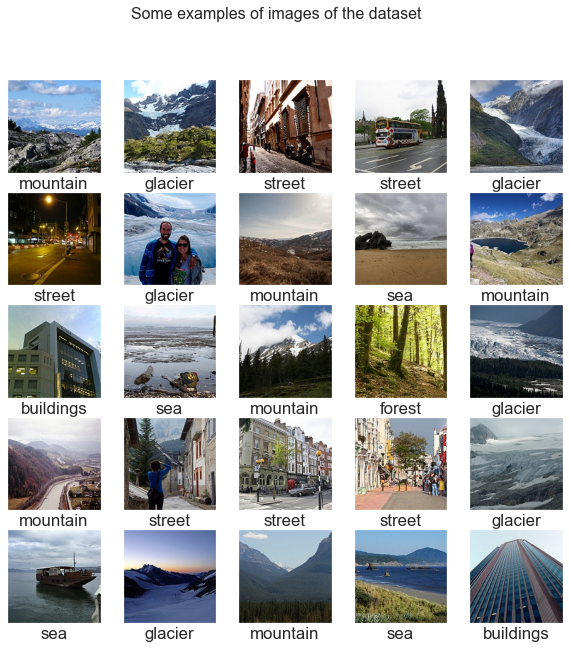

In [20]:
display_examples(class_names, train_images, train_labels)


# Building our model


In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [22]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 126s 1s/step - loss: 1.2122 - accuracy: 0.5578 - val_loss: 0.8131 - val_accuracy: 0.7072
Epoch 2/20
88/88 [==============================] - 140s 2s/step - loss: 0.7257 - accuracy: 0.7407 - val_loss: 0.6916 - val_accuracy: 0.7581
Epoch 3/20
88/88 [==============================] - 139s 2s/step - loss: 0.5534 - accuracy: 0.8069 - val_loss: 0.6933 - val_accuracy: 0.7602
Epoch 4/20
88/88 [==============================] - 131s 1s/step - loss: 0.4363 - accuracy: 0.8500 - val_loss: 0.6692 - val_accuracy: 0.7688
Epoch 5/20
88/88 [==============================] - 140s 2s/step - loss: 0.3260 - accuracy: 0.8939 - val_loss: 0.7103 - val_accuracy: 0.7613
Epoch 6/20
88/88 [==============================] - 134s 2s/step - loss: 0.2388 - accuracy: 0.9249 - val_loss: 0.6889 - val_accuracy: 0.7766
Epoch 7/20
88/88 [==============================] - 137s 2s/step - loss: 0.1755 - accuracy: 0.9484 - val_loss: 0.8118 - val_accuracy: 0.7492
Epoch 8/20
88

In [34]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(10,5))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "accuracy")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_accuracy")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

We should evaluate the model performance on test set



In [35]:
test_loss = model.evaluate(test_images, test_labels)


94/94 [==============================] - 8s 84ms/step - loss: 1.3355 - accuracy: 0.7577


We see that we achieve 0.76 accuracy on the testing test. We got a slight underfitting :(

Let's see how the classifier is doing on random images.

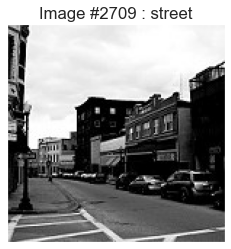

In [36]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

# Error analysis
We can try to understand on which kind of images the classifier has trouble.

In [37]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

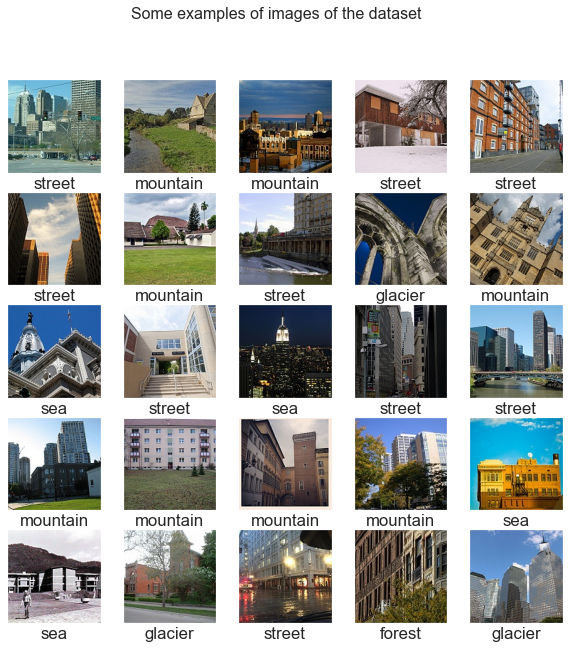

In [38]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

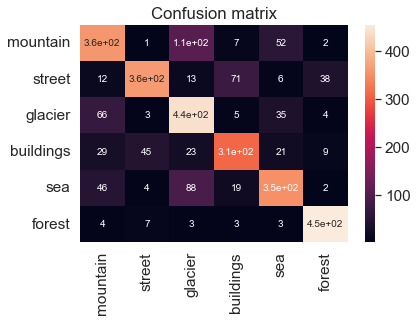

In [39]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

Conclusion: The classifier has trouble with 2 kinds of images.
It has trouble with street and buildings. Well, it can be understandable as as there are buildings in the street. It has also trouble with sea, glacier and moutain as well. It is hard for me to fully distinguish them. However, it can detects forest very accurately!

# Fine tuning VGG ImageNet

In [23]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

58892288/58889256 [==============================] - 82s 1us/step


In [24]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [25]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) # get the input shape of desired layer
layer_input = Input(shape = (9, 9, 512)) # a new input tensor to be able to feed the desired layer
# https://stackoverflow.com/questions/52800025/keras-give-input-to-intermediate-layer-and-get-final-output

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten(input_shape=train_images.shape[1:])(x)
x = Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))(x)
x = Dropout(0.5)(x)
x = Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))(x)
x = Dropout(0.3)(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [26]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
new_model.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 9, 9, 512)]       0         
_________________________________________________________________
block5_conv1 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv2 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_conv3 (Conv2D)        multiple                  2359808   
_________________________________________________________________
block5_pool (MaxPooling2D)   multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 64)          294976    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 64)         

In [28]:
history = new_model.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
88/88 [==============================] - 171s 2s/step - loss: 0.8446 - accuracy: 0.6745 - val_loss: 0.3250 - val_accuracy: 0.8839
Epoch 2/20
88/88 [==============================] - 178s 2s/step - loss: 0.3753 - accuracy: 0.8757 - val_loss: 0.3515 - val_accuracy: 0.8928
Epoch 3/20
88/88 [==============================] - 181s 2s/step - loss: 0.3171 - accuracy: 0.8956 - val_loss: 0.2897 - val_accuracy: 0.8985
Epoch 4/20
88/88 [==============================] - 179s 2s/step - loss: 0.2496 - accuracy: 0.9194 - val_loss: 0.2656 - val_accuracy: 0.9092
Epoch 5/20
88/88 [==============================] - 176s 2s/step - loss: 0.2235 - accuracy: 0.9310 - val_loss: 0.2907 - val_accuracy: 0.9099
Epoch 6/20
88/88 [==============================] - 176s 2s/step - loss: 0.1938 - accuracy: 0.9401 - val_loss: 0.3289 - val_accuracy: 0.8928
Epoch 7/20
88/88 [==============================] - 175s 2s/step - loss: 0.1552 - accuracy: 0.9482 - val_loss: 0.2969 - val_accuracy: 0.9131
Epoch 8/20
88

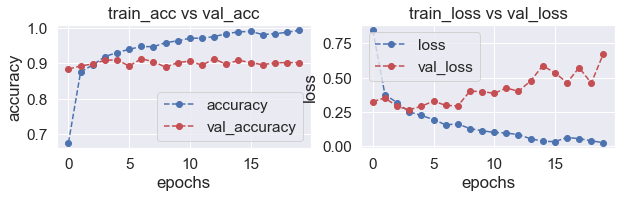

In [35]:
plot_accuracy_loss(history)

In [32]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.889


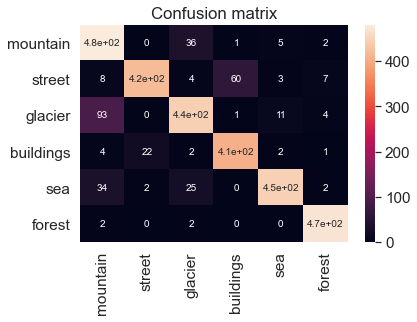

In [33]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()